In [1]:
import numpy as np
import cv2
import matplotlib.image as mpimg
import advanced_lane
import os
import glob
import matplotlib.pyplot as plt
%matplotlib inline  

## Clibrate the camera

In [2]:
calib_images = glob.glob('camera_cal/*')

In [3]:
nx, ny = 9, 6

objpoints = []
imgpoints = []

objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

for fname in calib_images:
    calib_image = cv2.imread(fname)
    gray = cv2.cvtColor(calib_image, cv2.COLOR_BGR2GRAY)  
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    # If found, draw corners
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

In [4]:
# now calibrate your camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

## Undistortion

In [5]:
def cal_undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

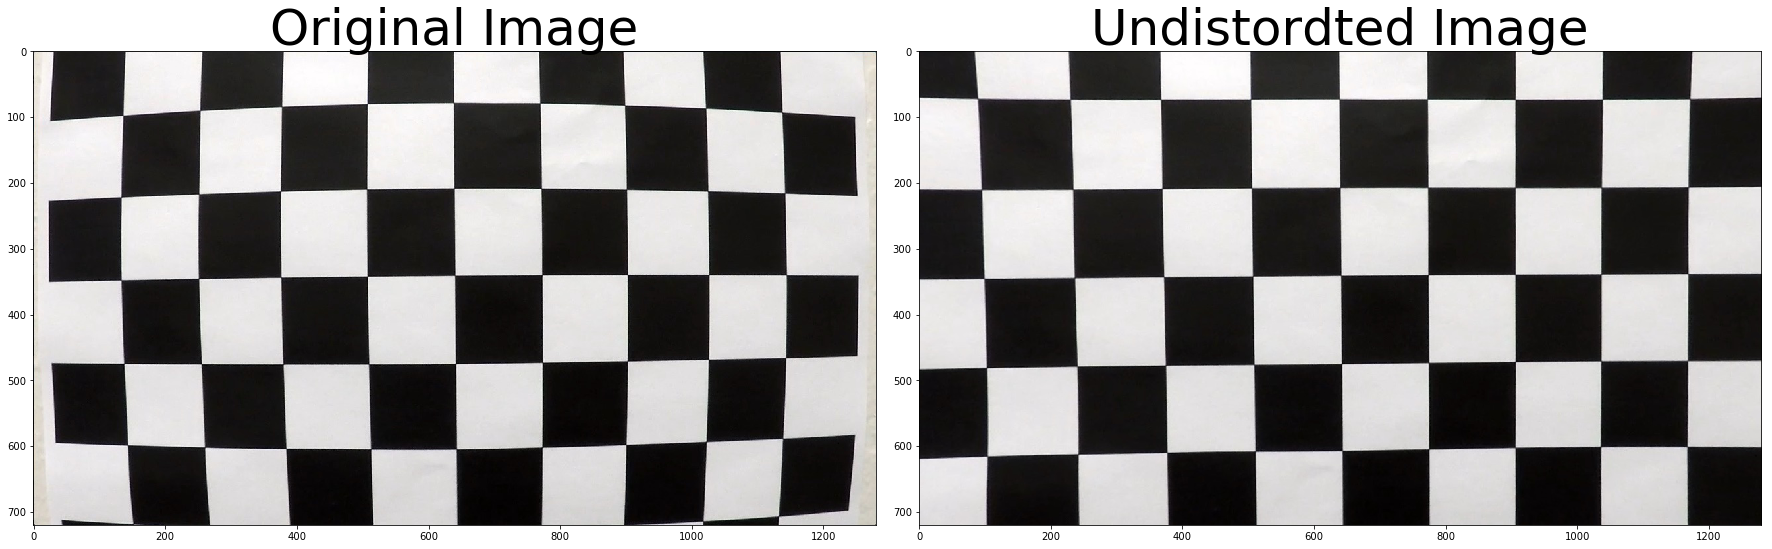

In [6]:
fisheye = mpimg.imread(calib_images[13])
unfisheye = cal_undistort(fisheye)
advanced_lane.plot_bfr_aftr([fisheye, unfisheye], ['Original Image', 'Undistordted Image'])

## Perspective transform

In [7]:
lane_test_image = mpimg.imread("test_images/test1.jpg")

In [ ]:
# warped = cv2.warpPerspective(thresholded, M, img_size , flags=cv2.INTER_LINEAR)
warped = advanced_lane.warper(lane_test_image)

In [ ]:
advanced_lane.plot_bfr_aftr([lane_test_image, warped], ['Original Image', 'Warped Image'])

## Threshold

In [ ]:
def scale(sobel):
    return np.uint8(255 * sobel / np.max(sobel))


def threshold(image,  thresh):
    binary = np.zeros_like(image)
    binary[(image >= thresh[0]) & (image <= thresh[1])] = 1
    return binary

def abs_sobel_thresh(image, orient='x', sobel_kernel=3, grad_thresh=(50, 200)):
    # Calculate directional gradient
    if orient=='x':
        sobel = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)  # Take the derivative
    else:
        sobel = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)  # Take the derivative

    abs_sobel = np.absolute(sobel)  # Absolute derivative
    scaled_sobel = scale(abs_sobel)
    # Apply threshold
    grad_binary = threshold(scaled_sobel, grad_thresh)
    return grad_binary

In [ ]:
binary_warped = advanced_lane.binarize(warped)
advanced_lane.plot_bfr_aftr([warped, binary_warped], ['Warped Image', 'Binarized Image'])

## Locate the Lane Lines and Fit a Polynomial

In [ ]:

def pipeline(image, lines_tracked=False):
    img = np.copy(image)
    #Undistort
    undistorted = cal_undistort(img)
    # Perspective transform
    warped = advanced_lane.warper(undistorted)
    #threshold
    binary_warped = advanced_lane.binarize(warped)
    #find first lines
    if not lines_tracked:
        left_fit_old, right_fit_old, ploty = advanced_lane.track_first_lines(binary_warped)
        lines_tracked = True
        left_curverad, right_curverad, center_offset = advanced_lane.curvature(left_fit_old, right_fit_old, ploty)
        result = advanced_lane.overlay_unwarp(img, binary_warped, left_fit_old, right_fit_old, ploty)

    else:    
        left_fit, right_fit, ploty = find_lane_lines(left_fit_old, right_fit_old)
        left_curverad, right_curverad, center_offset = advanced_lane.curvature(left_fit, right_fit, ploty)

        result = advanced_lane.overlay_unwarp(img ,binary_warped, left_fit, right_fit, ploty)
    curve_text = 'left curvature {} m:,  right curvature {} m:'.format(left_curverad, right_curverad)
    offset_text = 'Distance from center of lane is  {} m:'.format(center_offset)
    cv2.putText(result, curve_text, (200, 50), 0, 0.8, (0, 250, 0), 2, cv2.LINE_AA)
    cv2.putText(result, offset_text, (300, 100), 0, 0.8, (0, 255, 300), 2, cv2.LINE_AA)

    return result
 

In [ ]:
pipeline_result = pipeline(lane_test_image)
p = advanced_lane.plot_bfr_aftr([lane_test_image, pipeline_result], ['Original Image', 'Result Image'])

In [ ]:
import importlib
importlib.reload(advanced_lane) 



In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_image(image):
    result = pipeline(image)
    return result

In [ ]:
os.mkdir('example_output')

In [ ]:
output = 'video_output/test.mp4'

In [ ]:
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)

clip1 = VideoFileClip("project_video.mp4").subclip(0,5)
clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time clip.write_videofile(output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))